**Задание 1**

Запустить модель Stable Diffusion (в Jupyter Notebook от Anaconda или в Colab), придумать свой вариант промпта, связанный с вашим знаком зодиака, сгенерировать изображения, соответствующие промпту, прислать результат через ТУИС.

**Задание 2**

Загрузите из keras.datasets набор данных California Housing price regression dataset (https://keras.io/api/datasets/california_housing/), обучите нейронную сеть прогнозировать медианную цену домов в зависимости от количества комнат в доме, визуализируйте процесс обучения.

I'll put all my labs here https://github.com/hallame/deep_learning

Task01

In [3]:
!pip -q install -U keras-cv keras silence-tensorflow matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 145.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 63.8 MB/s eta 0:00:00


In [1]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00


In [4]:
#import
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import time, random, numpy as np, matplotlib.pyplot as plt

import keras            # Keras 3
import keras_cv         # KerasCV (Stable Diffusion)
import tensorflow as tf # ok après silence

#for ui
import ipywidgets as w
from IPython.display import display, clear_output

# Repro & outings
random.seed(42); np.random.seed(42)
os.makedirs("outputs/sd", exist_ok=True)

print("TF:", tf.__version__, "| Keras:", keras.__version__, "| KerasCV:", keras_cv.__version__)



TF: 2.19.0 | Keras: 3.12.0 | KerasCV: 0.9.0


In [5]:
#helpers utilities
def plot_images(images, title=None, figsize=(18, 6)):
    plt.figure(figsize=figsize)
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    if title:
        plt.suptitle(title, fontsize=14)
    plt.show()


In [8]:
#model

import gc
import tensorflow as tf
import keras
import keras_cv

def reset_tf():
    """Session cleaning TF/Keras ."""
    keras.backend.clear_session()
    tf.keras.backend.clear_session()
    gc.collect()

_SD = {}  # cache by size

def get_sd(size: int):
    """Retourn  pipeline StableDiffusion for 'size'. """
    if size not in _SD:
        reset_tf()
        _SD[size] = keras_cv.models.StableDiffusion(
            img_width=size, img_height=size, jit_compile=False
        )
    return _SD[size]

# sd = keras_cv.models.StableDiffusion(
#     img_width=256,
#     img_height=256,
#     jit_compile=False  # robust on CPU/Metal
# )


In [9]:
#zodiac signs
zodiac_style = {
    "aries":       "ram made of stardust, fiery aura",
    "taurus":      "majestic bull, emerald forest, grounded strength",
    "gemini":      "twin spirits, mirrored neon, duality and motion",
    "cancer":      "lunar crab, silver tides, protective shell",
    "leo":         "golden lion, royal crown, sunlit glow",
    "virgo":       "celestial maiden, wheat field, precise elegance",
    "libra":       "ethereal scales, balance of light and shadow",
    "scorpio":     "obsidian scorpion, midnight desert, mystic sting",
    "sagittarius": "celestial archer, comet trail, boundless horizon",
    "capricorn":   "sea-goat on marble cliff, ancient wisdom",
    "aquarius":    "water bearer of stars, electric waves, futurism",
    "pisces":      "twin koi in nebula waters, dreamy currents"
}

In [11]:
def build_prompt(sign: str) -> str:
    return f"""{zodiac_style.get(sign, 'zodiac spirit')}, fantasy art,
high quality, highly detailed, elegant, sharp focus,
concept art, dramatic lighting, volumetric light, 8k render""".strip()

# Widgets
sign_dd = w.Dropdown(
    options=[
        ("♈ Aries", "aries"), ("♉ Taurus", "taurus"), ("♊ Gemini", "gemini"),
        ("♋ Cancer", "cancer"), ("♌ Leo", "leo"), ("♍ Virgo", "virgo"),
        ("♎ Libra", "libra"), ("♏ Scorpio", "scorpio"), ("♐ Sagittarius", "sagittarius"),
        ("♑ Capricorn", "capricorn"), ("♒ Aquarius", "aquarius"), ("♓ Pisces", "pisces"),
    ],
    value="aquarius",
    description="Signe:",
)

size_dd = w.Dropdown(options=[256, 512], value=256, description="Size:")
batch_slider = w.IntSlider(min=1, max=4, step=1, value=3, description="Batch:")
gen_btn = w.Button(description="Generate", button_style="success")
out = w.Output()



def on_generate(_):
    with out:
        clear_output()
        sign = sign_dd.value
        size = int(size_dd.value)
        batch = int(batch_slider.value)

        prompt = build_prompt(sign)
        print("Prompt:", prompt)
        print(f"Size: {size}×{size} | Batch: {batch}")

        # re-use un pipeline from  cache
        sd = get_sd(size)

        t0 = time.time()
        images = sd.text_to_image(prompt, batch_size=batch)
        print(f"Time: {time.time()-t0:.1f}s")

        plot_images(images, title=f"Stable Diffusion — {sign.capitalize()}")

        saved = []
        for i, im in enumerate(images):
            path = f"outputs/sd/{sign}_{i+1}_{size}.png"
            plt.imsave(path, im)
            saved.append(path)
        print("Files saved:", saved)

gen_btn.on_click(on_generate)

ui = w.VBox([
    w.HBox([sign_dd, size_dd, batch_slider]),
    gen_btn,
    out
])
display(ui)


Task02

In [12]:
#import
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# cut the logs TF
try:
    from silence_tensorflow import silence_tensorflow
    silence_tensorflow()
except Exception:
    pass

# Reproducibility
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

print("TF:", tf.__version__, "| Keras:", keras.__version__)

TF: 2.19.0 | Keras: 3.12.0


In [13]:
#uploading data
USE_SKLEARN_FALLBACK = False
try:
    from keras.datasets import california_housing
    _ = california_housing.load_data
except Exception:
    USE_SKLEARN_FALLBACK = True

FEATURE_NAMES = ["MedInc","HouseAge","AveRooms","AveBedrms",
                 "Population","AveOccup","Latitude","Longitude"]

if not USE_SKLEARN_FALLBACK:
    (x_train, y_train), (x_test, y_test) = california_housing.load_data()
    X = np.vstack([x_train, x_test]).astype(np.float32)
    y = np.concatenate([y_train, y_test]).astype(np.float32)  # unit
    from sklearn.datasets import fetch_california_housing
    data = fetch_california_housing()
    X = data.data.astype(np.float32)
    y = data.target.astype(np.float32)  # unit = 100k$

df = pd.DataFrame(X, columns=FEATURE_NAMES)
df["MedHouseVal"] = y

print(df.shape, " | y min/med/max:", float(y.min()), float(np.median(y)), float(y.max()))
df.head()


743530/743530 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(20640, 9)  | y min/med/max: 0.1499900072813034 1.7970000505447388 5.000010013580322


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.880001,-122.230003,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.860001,-122.220001,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.849998,-122.239998,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.849998,-122.250000,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.849998,-122.250000,3.422


In [14]:
#selct only AveRooms +split (baseline 1D)
X_one = df[["AveRooms"]].values.astype(np.float32)
y_all = df["MedHouseVal"].values.astype(np.float32)  # 100k$

# Split 80/10/10
X_train, X_temp, y_train, y_temp = train_test_split(
    X_one, y_all, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Standardisation X
x_scaler = StandardScaler().fit(X_train)
X_train_s = x_scaler.transform(X_train)
X_val_s   = x_scaler.transform(X_val)
X_test_s  = x_scaler.transform(X_test)

# Standardisation y (stability ++)
y_scaler = StandardScaler().fit(y_train.reshape(-1,1))
y_train_s = y_scaler.transform(y_train.reshape(-1,1))
y_val_s   = y_scaler.transform(y_val.reshape(-1,1))
y_test_s  = y_scaler.transform(y_test.reshape(-1,1))

X_train_s[:3], y_train_s[:3].ravel()[:3]


(array([[-0.17491654],
        [-0.4028354 ],
        [ 0.08821608]], dtype=float32),
 array([-0.90118915,  1.5127715 , -0.2992126 ], dtype=float32))

In [15]:
#Keras model (1D regression) + compilation
def build_reg():
    m = keras.Sequential([
        layers.Input(shape=(1,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    m.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return m

reg = build_reg()
reg.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

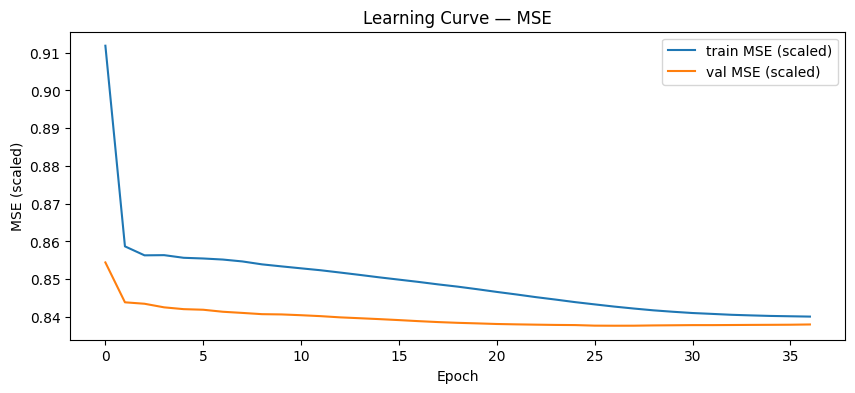

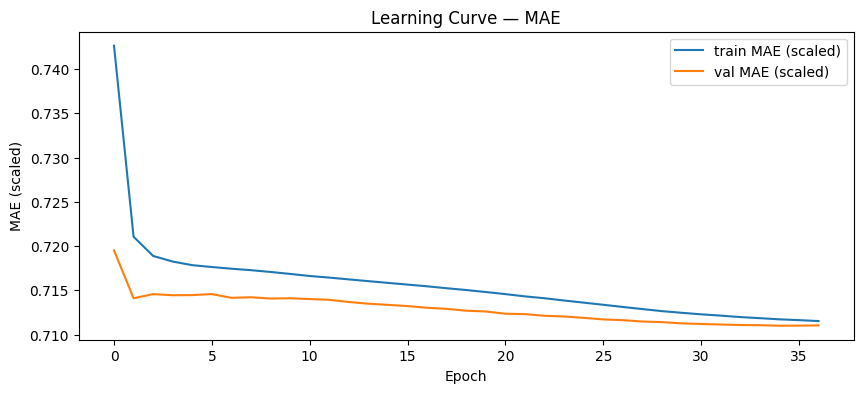

In [16]:
#train &  curves
early = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

hist = reg.fit(
    X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=200, batch_size=128, verbose=0, callbacks=[early]
)

# Courbes (loss/mae in normal standardized scale)
plt.figure(figsize=(10,4))
plt.plot(hist.history["loss"], label="train MSE (scaled)")
plt.plot(hist.history["val_loss"], label="val MSE (scaled)")
plt.xlabel("Epoch"); plt.ylabel("MSE (scaled)"); plt.legend(); plt.title("Learning Curve — MSE"); plt.show()

plt.figure(figsize=(10,4))
plt.plot(hist.history["mae"], label="train MAE (scaled)")
plt.plot(hist.history["val_mae"], label="val MAE (scaled)")
plt.xlabel("Epoch"); plt.ylabel("MAE (scaled)"); plt.legend(); plt.title("Learning Curve — MAE"); plt.show()


Test MSE: 1.0879 | Test MAE: 0.8180  (unit = 100k$)


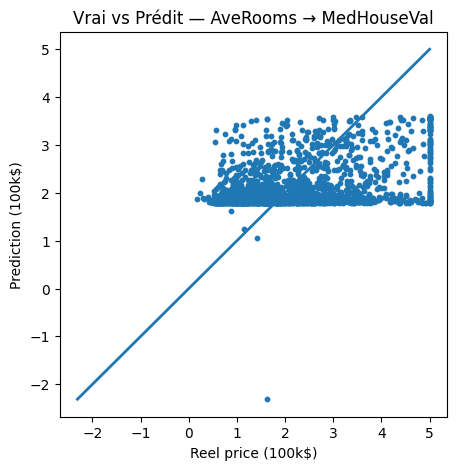

MAE (100k$): 0.8179500102996826
R²: 0.1653270721435547


In [17]:
# Evaluation test & visualization (+ inverse transform)
y_pred_s = reg.predict(X_test_s, verbose=0)
y_pred   = y_scaler.inverse_transform(y_pred_s).ravel()  # 100k$

# Metrics in origin  unit (100k$)
mse = np.mean((y_pred - y_test)**2)
mae = np.mean(np.abs(y_pred - y_test))
print(f"Test MSE: {mse:.4f} | Test MAE: {mae:.4f}  (unit = 100k$)")

# Scatter reel vs predict (100k$)
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=10)
mn, mx = float(min(y_test.min(), y_pred.min())), float(max(y_test.max(), y_pred.max()))
plt.plot([mn, mx], [mn, mx], lw=2)
plt.xlabel("Reel price (100k$)"); plt.ylabel("Prediction (100k$)")
plt.title("Vrai vs Prédit — AveRooms → MedHouseVal")
plt.show()

print("MAE (100k$):", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


In [18]:
def predict_price_from_rooms(avg_rooms_list):
    """
    Retourne [(AveRooms, prix_en_100k$, prix_en_$)]
    """
    Xq = np.array(avg_rooms_list, dtype=np.float32).reshape(-1,1)
    Xq_s = x_scaler.transform(Xq)
    yq_s = reg.predict(Xq_s, verbose=0)
    yq_100k = y_scaler.inverse_transform(yq_s).ravel()  # 100k$
    yq_dollars = (yq_100k * 100_000).round(0).astype(np.int64)
    return list(zip(avg_rooms_list, yq_100k.round(3), yq_dollars))

predict_price_from_rooms([2.0, 3.0, 4.5, 6.0, 8.0])


[(2.0, np.float32(2.006), np.int64(200566)),
 (3.0, np.float32(1.913), np.int64(191270)),
 (4.5, np.float32(1.808), np.int64(180761)),
 (6.0, np.float32(2.095), np.int64(209451)),
 (8.0, np.float32(3.504), np.int64(350406))]